# トークトリアル 3

# 化合物フィルタリング：好ましくない部分構造

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Maximilian Driller and  Sandra Krüger

## このトークトリアルの目的

いくつか私たちのスクリーニングライブラリーに含めたくない部分構造があります。このトークトリアルでは、そのような好ましくない部分構造の様々なタイプを学び、そしてRDKitを使ってそれらの部分構造を見つけ、ハイライトする方法を学びます。

## 学習の目標

### 理論

* 好ましくない部分構造とは何か?
* 汎分析干渉化合物 Pan Assay Interference Compounds (PAINS)  

### 実践

* ChEMBLデータベースから化合物のセットを読み込む（**トークトリアル 2**　で準備したもの）
* RDKitでの実装を利用し好ましくない部分構造をフィルターにかけ取り除く
* 独自の好ましくない部分構造のリストを作成し、フィルタリングを実施
* 部分構造の検索とハイライト

## レファレンス

* Brenk et al.: "Lessons learnt from assembling screening libraries for drug discovery for neglected diseases" <i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444 (https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)
* Brenk et al.: 好ましくない構造のSMARTS定義 (<i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444 のSupporting InformationのTable  1(https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)
* Baell et al.: "New substructure filters for removal of Pan Assay Interference Compounds (PAINS) from screening libraries and for their exclusion in bioassays" <i>J. Med. Chem.</i> (2010), <b>53(7)</b>,2719-2740 (https://pubs.acs.org/doi/abs/10.1021/jm901137j)
* Rajarshi GuhaによるPAINSのフォーマットのSLN(Baell et al. publication) からSMARTSへの変換: http://blog.rguha.net/?p=850; RDKit使われているSMARTSはGreg LandrumがRajarshi GuhaのKNIMEワークフローから収集・整理したものです: http://rdkit.blogspot.com/2015/08/curating-pains-filters.html
* https://en.wikipedia.org/wiki/Pan-assay_interference_compounds
* TDT -Tutorial2014 - (https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb)

_____________________________________________________________________________________________________________________


## 理論

### 好ましくない部分構造

部分構造には好ましくないものがあります。例えば毒性あるいは反応性があるといった理由や、薬物動態学的特性が好ましくないという理由、あるいは特定のアッセイに干渉する可能性が高いという理由です。
今日の医薬品探索ではよくハイスループットスクリーニング ([HTS wikipedia](https://en.wikipedia.org/wiki/High-throughput_screening))　を実施します。好ましくない部分構造をフィルタリングすることで、より望ましいスクリーニングライブラリを構築することができます。これにより、スクリーニングの前にライブラリの数を減らすことができ、時間と資源の節約につながります。

Brenkらは顧みられない病気の治療のための化合物の探索に使用するスクリーニングライブラリーをフィルタリングするため、好ましくない部分構造のリストを作成しました([<i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139))。好ましくない特徴の例として、ニトロ基（変異原性の問題）、スルホン酸基とリン酸基（薬物動態学的特性が好ましくない可能性が高い）、2-ハロピリジンとチオール基（反応性の問題）、といったものが挙げられます。

好ましくない部分構造のリストは上記の文献に報告されており、このトークトリアルの実践編でも使用します。

### 汎分析干渉化合物 Pan Assay Interference Compounds (PAINS)

#### 概要

PAINS ([PAINS wikipedia](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds)) は実際には偽陽性にも関わらず、HTSでしばしばヒットとして見出される化合物です。PAINSは特定の一つのターゲット分子と反応するというよりもむしろ、非特異的に多数のターゲット分子と反応する傾向があります。通常、非特異的な結合もしくはアッセイの構成要素との相互作用により、様々なアッセイで様々なタンパク質に対して見かけ上結合します。
[![PAINS](./images/PAINS_Figure.jpeg)](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif)
    <div align="center">Figure 1:汎分析干渉化合物（Pan Assay Interference Compounds、PAINS）の観点における特異的結合と非特異的結合。図は[wikipedia](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif)より引用 </div>

#### Baellらによる文献で用いられたフィルター

Baellらはアッセイのシグナルに干渉する部分構造に焦点を当てました ([<i>J. Med. Chem.</i> (2010), <b>53(7)</b>,2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j))。そのようなPAINSを見つけるのに役立つ部分構造について記述し、部分構造フィルタリングに利用できるリストを提供しました。

## 実践

### データの読み込みと可視化

まず、必要なライブラリをインポートし、**トークトリアル T2** でフィルタリングしたデータセットを読み込み、はじめの分子群を描画します。

In [1]:
import pandas
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

In [2]:
filteredData = pandas.read_csv("../data/T2/EGFR_compounds_lipinski.csv", delimiter=";", index_col=0)
filteredData.drop(['HBD','HBA','MW','LogP'], inplace=True, axis=1) # 不必要な情報の除去
print ('Dataframe shape: ', filteredData.shape) # データフレームの次元をプリント
filteredData.head(5)

Dataframe shape:  (4523, 6)


,molecule_chembl_id,units,IC50,smiles,pIC50,rule_of_five_conform
0,CHEMBL63786,nM,0.003,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,yes
1,CHEMBL53711,nM,0.006,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,yes
2,CHEMBL35820,nM,0.006,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,yes
3,CHEMBL53753,nM,0.008,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,yes
4,CHEMBL66031,nM,0.008,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,yes


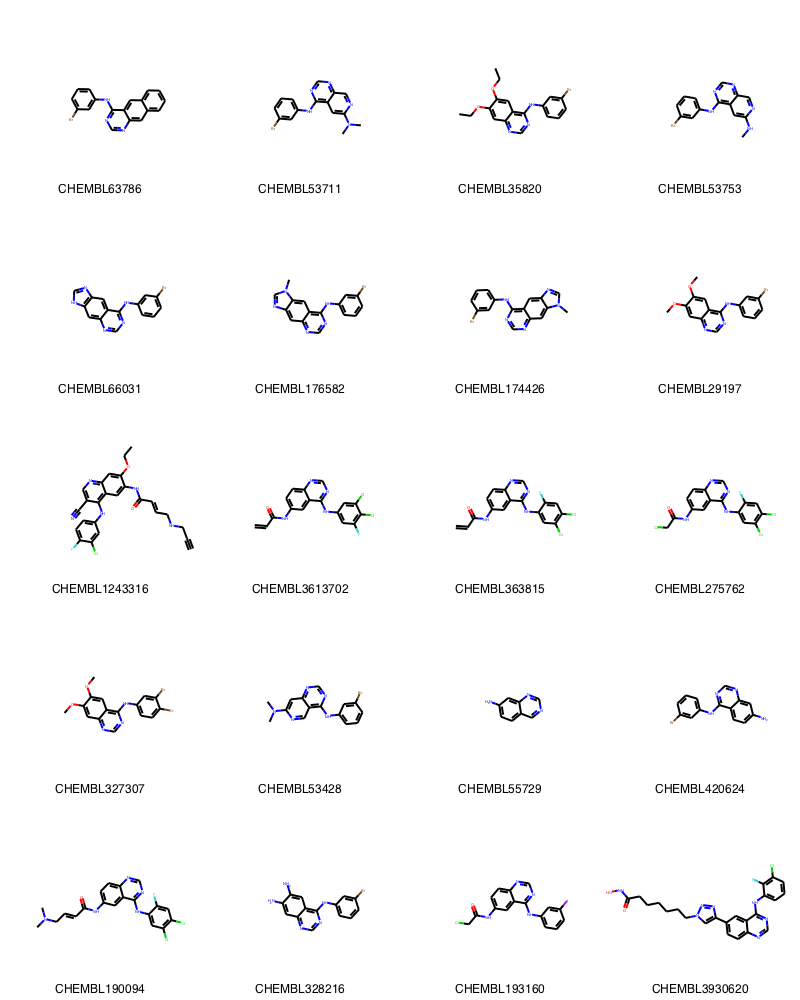

In [3]:
PandasTools.AddMoleculeColumnToFrame(filteredData, smilesCol='smiles') # 分子を列に追加
# 最初の２０個の分子を描画
Draw.MolsToGridImage(list(filteredData.ROMol[0:20]), 
                    legends=list(filteredData.molecule_chembl_id[0:20]), 
                    molsPerRow=4) 

### RDKitを使用してPAINSをフィルタリング

PAINSフィルターはすでにRDKitに実装されています([RDKit Documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html))。使ってみましょう！

In [4]:
from rdkit.Chem.FilterCatalog import *
params = FilterCatalogParams()
# 全　PAINS (A, B and C)　からカタログを構築
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

Number of compounds with PAINS: 394
Number of compounds without PAINS: 4129 (=remaining compounds)


,CompID,CompMol,unwantedID
0,CHEMBL93032,,Catechol_a(92)
1,CHEMBL2029429,,Anil_di_alk_a(478)
2,CHEMBL2029428,,Anil_di_alk_a(478)
3,CHEMBL4071474,,Anil_di_alk_a(478)
4,CHEMBL4126630,,Anil_di_alk_a(478)
5,CHEMBL3663926,,Anil_di_alk_a(478)
6,CHEMBL3663925,,Anil_di_alk_a(478)
7,CHEMBL3663936,,Anil_di_alk_a(478)
8,CHEMBL3663923,,Anil_di_alk_a(478)
9,CHEMBL3663934,,Anil_di_alk_a(478)

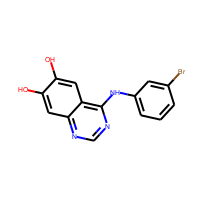
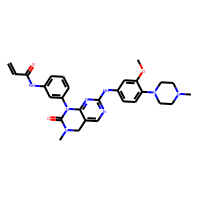
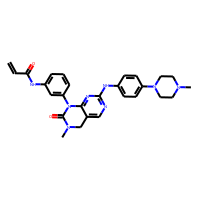
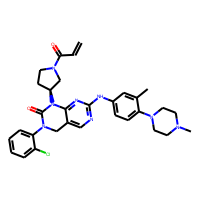
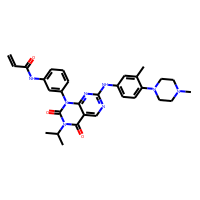
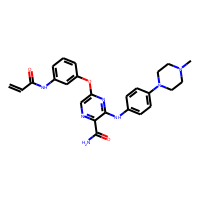
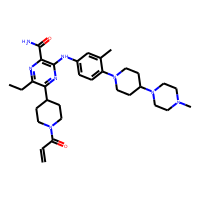
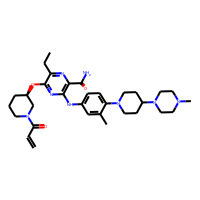
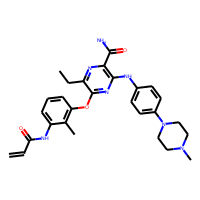
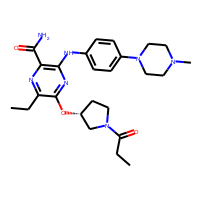

In [5]:
# フィルタリングしたデータを格納するための空のデータフレームを作成
rdkit_highLightFramePAINS = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID'))
rdkit_noPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
rdkit_withPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))

# フィルタリングしたデータフレームのインデックスと行についてforループを回す
for i,row in filteredData.iterrows():
    curMol = Chem.MolFromSmiles(row.smiles) # 現在の分子
    match = False # Falseにmatchを設定
    rdkit_PAINSList = []
    # 最初のmatchを取得
    entry = catalog.GetFirstMatch(curMol)
    
    if entry!=None:
        # 現在の好ましくない部分構造の名前をリストに追加
        rdkit_PAINSList.append(entry.GetDescription().capitalize())
        # データフレームに関連するマッチング情報を追加
        rdkit_highLightFramePAINS.loc[len(rdkit_highLightFramePAINS)] = [row.molecule_chembl_id, curMol,
        entry.GetDescription().capitalize()]
        match = True
    if not match:
        # PAINSを含まない化合物のデータフレームに追加
        rdkit_noPAINS.loc[len(rdkit_noPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
    else: 
        # PAINSを含む化合物のデータフレームに追加
        # 好ましくない部分構造を含むデータフレームに関連する情報を加える
        rdkit_withPAINS.loc[len(rdkit_withPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50, entry.GetDescription().capitalize()]

print("Number of compounds with PAINS: %i"%(len(rdkit_withPAINS)))
print("Number of compounds without PAINS: %i (=remaining compounds)"%(len(rdkit_noPAINS)))

rdkit_highLightFramePAINS.head(10)

**訳注(04/2020)**

訳者はPythonに詳しくないので`rdkit_highLightFramePAINS.loc[len(rdkit_highLightFramePAINS)]` の部分に関する備忘録です。  
`loc`はPandas DataFrameで行をindexで指定する方法です。 `len(~)`でDataFrameの行数を取得することですでにデータが入っている行数がわかります。  
DataFrameのindexは0から始まっているので、DataFrameの行数をindexとして指定することで、新しいデータを新しい行（既存の行数+1の行）に追加することになるのだと思います。

また、PAINSの利用例はRDKit Documentationの[こちら](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html#rdkit.Chem.rdfiltercatalog.FilterCatalogEntry)に同様のコードが見られます。

**訳注ここまで**

### 好ましくない/毒性の懸念される部分構造でフィルタリング(Brenkのリスト)

RDKitには、PAINSのような好ましくない部分構造のリストがいくつかすでに実装されています。ですが、実装されていないRDKit外部のリストを使って部分構造の一致検索を行うことも可能です。ここではBrenkらによる文献([<i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139))のsupporting informationで提供されているリストを使用します。

注）　データをダウンロードし、dataフォルダにcsvファイルとして保存済みです（形式は name-space-SMARTS です）。まず、データを読み込みます。

In [6]:
unwantedSubs = []
unwantedNames = []

for line in open('../data/T3/unwantedSubstructures.csv', 'r'):
    if not line.startswith("#"): # ヘッダーを無視
        splitted = line.strip().split(" ") # 各行を分割
        m = Chem.MolFromSmarts(splitted[1]) # SMARTSから分子を生成
        name = splitted[0].capitalize() # nameに名前を保存
        unwantedNames.append(name) # 好ましくない部分構造の名前をリストに追加
        unwantedSubs.append(m) # 好ましくない部分構造をリストに追加
print("Number of unwanted substructures in list =", len(unwantedSubs)) # 好ましくない部分構造の数を表示

Number of unwanted substructures in list = 104


**訳注(04/2020)**

Pythonやプログラミング初心者仲間のための蛇足・・・  
「unwantedSubstructures.csv」ファイルは１行目のみ「#name smart」となっています。`if not line.starwith(#)`の部分で「#」から始まる１行目(header)を飛ばしています。  
`strip()`は文字列の先頭・末尾の余分な文字を削除するメソッドで、空白文字としてスペース、タブ、改行も取り除けるのでcsvの改行文字を除いているのだと思います。  
`split(" ")`はスペースで分割しているので、改行文字を取り除いた各行の`name-space-SMARTS`形式を`space`で分割し`name`と`SMARTS`にしているのだと思います。   
こう考えると`splitted[0]`が`name`、`splitted[1]`が`SMARTS`になっていることがわかりやすい気がします。  

**訳注ここまで**

２、３個部分構造を見てみましょう　(すべてのSMARTSが表示できるわけではありません。一部を選んでいます。)。

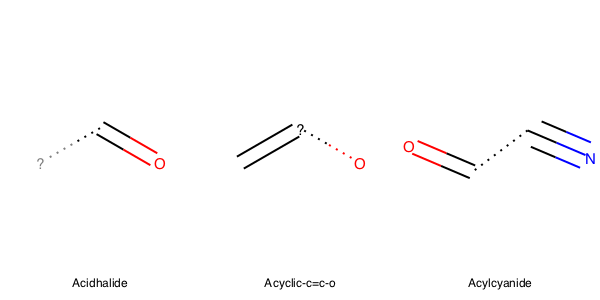

In [8]:
Chem.Draw.MolsToGridImage(list(unwantedSubs[2:5]), subImgSize=(200, 300), legends=unwantedNames[2:5])

これらの好ましくない部分構造とマッチするものがあるか、フィルタリングしたデータフレームの中を検索してみます。

In [7]:
# フィルタリングしたデータを格納するためのデータフレームを作成
highLightFrameUNW = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID', 'unwSubstr'))
noUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
withUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))
molsToDraw = []

# データセットの各化合物に対して
for i,row in filteredData.iterrows(): # フィルタリングしたデータフレームのインデックスと行についてfor ループを回す
    curMol = Chem.MolFromSmiles(row.smiles) # 現在の分子
    match = False # Falseにmatchを設定
    unwantedList = []
    molsToDraw.append(curMol)
    
    # 全ての好ましくない部分構造を検索
    for idx, unwSub in enumerate(unwantedSubs):
        # 部分構造があるかチェック
        if curMol.HasSubstructMatch(unwSub): # 現在の分子が好ましくない部分構造を有する場合
            match = True # matchをTrueに設定
            unwantedList.append(unwantedNames[idx]) # 好ましくない部分構造の名前をリストに追加
            # 関連する情報をデータフレームに追加
            highLightFrameUNW.loc[len(highLightFrameUNW)] = [row.molecule_chembl_id, curMol, unwantedNames[idx], unwSub]
    if not match: # 一致する部分構造が見つからない場合
        noUnwanted.loc[len(noUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
        # 欲しい部分構造のデータフレームに関連情報を追加
    else: # 一致が見つかった場合
        withUnwanted.loc[len(withUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50, unwantedList] #　好ましくない部分構造データフレームに関連する情報を追加

print("Number of compounds with unwanted substructures: %i"%(len(withUnwanted)))
print("Number of compounds without unwanted substructures: %i (=remaining compounds)"%(len(noUnwanted)))

Number of compounds with unwanted substructures: 2356
Number of compounds without unwanted substructures: 2167 (=remaining compounds)


,CompID,CompMol,unwantedID,unwSubstr
0,CHEMBL63786,,Polycyclic-aromatic-hydrocarbon,
1,CHEMBL1243316,,Aliphatic-long-chain,
2,CHEMBL1243316,,Michael-acceptor,
3,CHEMBL1243316,,Triple-bond,

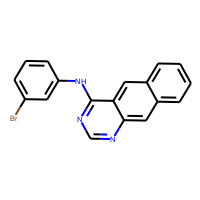
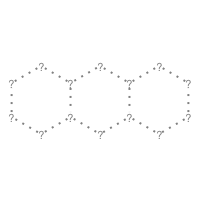
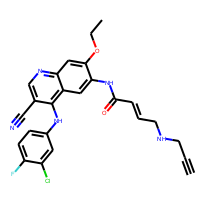
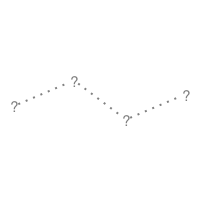
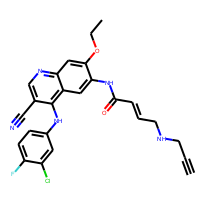
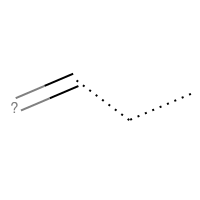
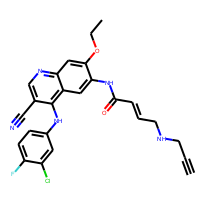
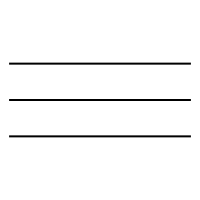

In [8]:
highLightFrameUNW.head(4)

部分構造を分子の中で直接ハイライトすることもできます。

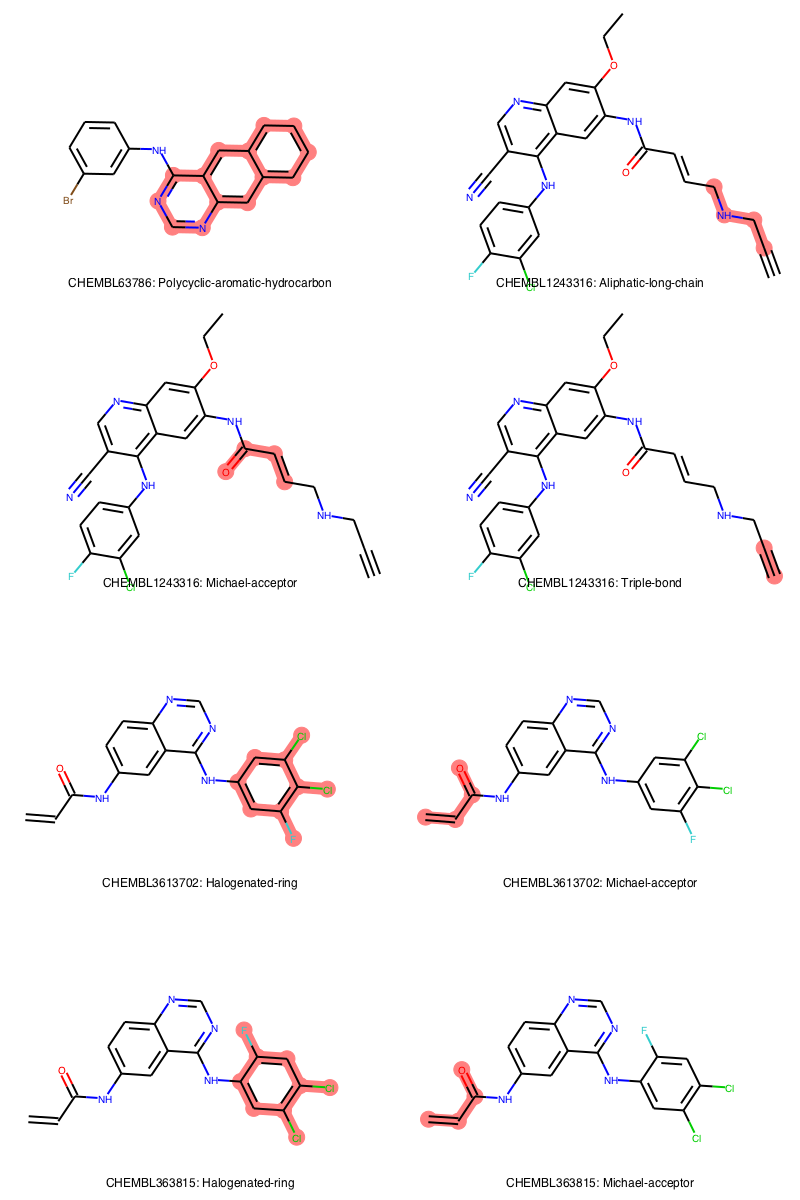

In [9]:
first_highLightFrameUNW = highLightFrameUNW.head(8) # リストの最初の8エントリーのサブセット

# 分子を描画し、好ましくない部分構造をハイライトする 
Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=2, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["CompID"]+": "+first_highLightFrameUNW["unwantedID"]))

**訳注(04/2020)**

Pythonやプログラミング初心者仲間のための蛇足・・・  
`[m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])]`の部分ですが、`enumerate`はインデックス番号と要素を同時に取得するメソッドで、ここではそれぞれ**i**と**m**を割り当てています。  
要素**m**分子がもつ好ましくない部分構造を見つけるために、RDKitの`GetSubstructMatch`を使用しており、検索対象の好ましくない部分構造を`unwSubstr`列のインデックス**i**を参照するという形で実行されています。

**訳注ここまで**

例をSVGファイルとして保存します。

In [10]:
# イメージをファイルに保存
img = Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=3, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["unwantedID"]), useSVG=True)

# SVGデータの取得
molsvg = img.data

# 不透明な背景を透明に置き換える
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "24px");

# 変更されたSVGデータをファイルに保存
f = open("../data/T3/substructures.svg", "w")
f.write(molsvg)
f.close()

好ましくない部分構造を持つ化合物と持たない化合物のリストを保存。

In [12]:
# 好ましくない部分構造を有する化合物をcsvファイルに書き出し
withUnwanted.to_csv("../data/T3/EGFR_compounds_lipinski_noPAINS.csv", sep=',') 

# 好ましくない部分構造を持たない化合物をcsvファイルに書き出し
noUnwanted.to_csv("../data/T3/EGFR_compounds_lipinski_noPAINS_noBrenk.csv", sep=',') 

# 好ましくない部分構造を有する化合物のcsvファイルの最初のいくつかを表示
noUnwanted.head() 

,ChEMBL_ID,smiles,pIC50
0,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL176582,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000


見つかった好ましくない部分構造をさらに解析します。

In [14]:
# 最も頻度の高い化合物の数を数えます。
unwCounts = {}
for ele in highLightFrameUNW.values:
    unw = ele[2] # highLightFrameUNWデータフレームに含まれる好ましくない部分構造のID
    if unwCounts.get(unw, "empty") == "empty": # 好ましくない構造のIDがまだ辞書に含まれていない場合
        unwCounts[unw] = [1, ele[3]] # 1を付与し、辞書の好ましくない構造に追加
    else: # もしkey （好ましくない構造のID）がすでに存在しているなら、出現回数の値を１増やす 
        unwCounts[unw][0] += 1

frequentUNW = []
frequentUNWNames = []

# unwCountsに含まれる構造: IDをkey、出現頻度と分子をvalueとしてもつ辞書
# 例　('acyclic-C=C-O', [7, <rdkit.Chem.rdchem.Mol object at 0x7fa58fc06710>])

# 部分構造の頻度で辞書をソートする
for key, value in sorted(unwCounts.items(), key=lambda kv: kv[1][0], reverse=True):
    frequentUNW.append(value[1]) # 部分構造
    frequentUNWNames.append(key)

**訳注(04/2020)**

Pythonやプログラミング初心者仲間のための蛇足・・・  
`for ele in highLightFrameUNW.values`の部分ですが、`values`はDataFrameの実際のデータの値で、NumPyの配列`ndarray`です。
DataFrame`highLightFrameUNW`を参照していただければわかると思いますが、`ele[2]`は２列目`unwantedID`列を、`ele[3]`は3列目`unwSubstr`列の要素を指定しています。  
`unwCounts.get(unw, "empty")`の部分ですが、`get(key[, default])`は辞書型においてkey が辞書にあれば key に対する値を、そうでなければ default を返します。ですので、今回は辞書`unwCounts`に**key**`unw(unwntedID, ele[2])`があるかどうかを検索し、なければ**defalut**として`empyt`を返すというようになっています。辞書`unwCounts`のkeyは`unwntedID`、valueはリスト`[出現回数,  好ましくない部分構造]`となっているので、**辞書に含まれていない好ましくない部分構造**の場合は新しくエントリーを辞書に追加して値を出現回数を1に設定、**すでに辞書に含まれている構造**の場合は出現回数`[unw][0]`をインクリメントするという手順になっているのだと思います。

**訳注ここまで**

頻度の高い部分構造の上位８個を描画します。

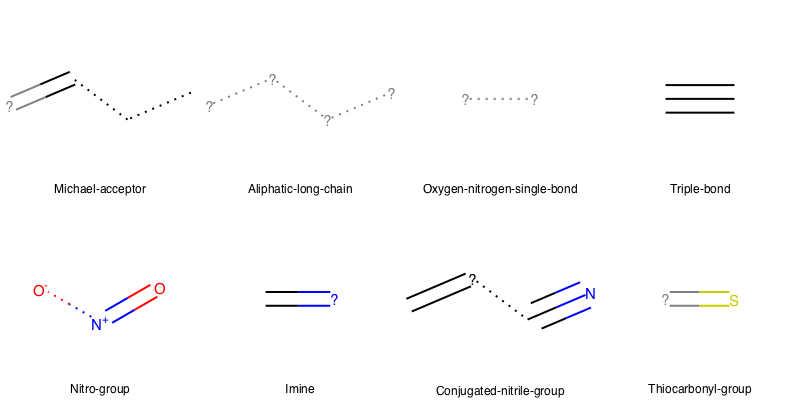

In [15]:
# 上位８個の頻度の高い部分構造
Draw.MolsToGridImage(mols=list(frequentUNW[0:8]), 
                     legends=list(frequentUNWNames[0:8]),
                     molsPerRow=4)

## ディスカッション

このトークトリアルでは、好ましくない部分構造の検索を行う２つの方法を学びました。: 
* RDKitにすでに実装されている `FilterCatalog`クラス、そして、
* RDKitに含まれていない外部のリストと`HasSubstructMatch()`関数です。

実際のところ、PAINSを部分構造検索で実装することもできます。また、BrenkらによるリストもすでにRDKitに実装されています。実装済みのその他のリストについては ([RDKit Documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html))を参照してください。 

これまで、`HasSubstructMatch()`関数を使用してきましたが、これは一つの化合物あたり一つのマッチ結果しか出しません。[`GetSubstructMatches()`](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdchem.Mol-class.html#GetSubstructMatches)　関数を使用すると、一つの化合物に含まれる全ての部分構造を見つけることができます。
同様にPAINSに関して、一つの分子あたり、最初にマッチしたもの `GetFirstMatch()` だけをみてきました。もし、全てのPAINSをフィルタリングして除去したいのであればこれで十分です。ですが、ある分子のもつ全ての危険な部分構造を見るために、`GetMatches()`を使用することもできます。一つの分子あたり全てのマッチする部分構造を考慮しているわけではないので、最後に描画した部分構造が実際に最も頻度の高いものであったと言うことはできません。ですが、頻度が高いということだけは明らかです。

見つかった部分構造は２つの異なる方法で処理できます。
* 部分構造検索をフィルターとして適用し、引っかかった化合物を、資金と時間の節約のため、さらなる試験からは除外する
* あるいは警告として使用することもできます。好ましくない部分構造を有する分子にフラグを立てることができます。（例えば、化学者や毒性学者•・・といった）専門家の目から見て、経験に基づき判断することができるかもしれません。もし、各部分構造がそこまでクリティカルなものでなければ、スクリーニングの対象化合物として含めることも可能です。

ここでは、機械学習に使用するために、あまりに多くの化合物を削除することはしたくなかったので、好ましくない部分構造をフィルタリングで除去することはしません。また、部分構造によるフィルタリングは、後ほど実際のスクリーニング実験を行うまえに適用することもできます。警告（アラート）のフラッグを設定することも可能で、そうすれば（PAINSやBrenk等どのようなリストにでも順じて）好ましくない部分構造についての情報を保持し、あとで考慮することが可能です。

## クイズ
* なぜスクリーニングライブラリーから「PAINS」を取り除くことを考えるべきなのでしょうか？これらの化合物の問題点とは何でしょうか？  
* ある好ましくない部分構造を取り除く必要がないような状況を見つけることはできますか？
* このチュートリアルで使用した部分構造はどうやってエンコードされていましたか？